# Predicting Credit Card Default

Using data provided by UCI Machine Learning Repository, this notebook will use feature engineering, 3 feature selection methods and 4 different algorithms to predict if a credit card user will default. The data will be split into 3 subsets: training data to train each algorithm, testing data to check the trained model, and validation data which, in practice, will be used to validate the desired model after put into production.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import tree
from scipy import stats
import random
from datetime import datetime
import beepy as beep
from collections import Counter
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict,cross_validate
from sklearn.model_selection import cross_val_predict, RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, roc_curve
from sklearn.metrics import recall_score, roc_auc_score, classification_report, precision_recall_curve
from sklearn.metrics import precision_recall_curve, average_precision_score, ConfusionMatrixDisplay 
from tabulate import tabulate
from sklearn.datasets import make_classification
from mlxtend.classifier import OneRClassifier
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline, Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFECV, RFE
import statsmodels.api as sm
from scikitplot.metrics import plot_lift_curve, plot_roc_curve
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load Data
data=pd.read_csv('credit_card_default.csv')

In [3]:
# Remove weird first column and initial analysis columns from the end
poplist=("Unnamed: 0","ID",'u','train','test','validate','data.group')
for i in poplist:
    data.pop(i)
data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
# Data dictionary of source variables
colHeads=("Original Variable Name","New Variable Name","Description/Values")
ogVars=["LIMIT_BAL","SEX","EDUCATION","MARRIAGE","AGE","PAY_X","BILL_AMTX","PAY_AMTX","DEFAULT"]
nwVars=["N/A",'N/A','N/A','N/A','N/A','PAY_MONTH (PAY_SEPT, etc.)',
        'BILL_AMT_MONTH (BILL_AMT_SEPT, etc.)','PAY_AMT_MONTH (PAY_AMT_MONTH, etc.)','N/A']
descriptions=['Amount of initial credit given.','Gender (1 = male, 2 = female)',
              'Highest education level. (1 = Graduate School, 2 = Undergraduate School, 3 = High school, 4 = other)',
             'Marital status (1 = married, 2 = single, 3 = other)','Age (year)',
             'History of past payment. PAY_1 is the repayment status for September, PAY_2 is the repayment status for August, etc. -1 means duly paid, 1 mean payment was delayed 1 month, 2= two months delayed, etc.',
             'Amount on bill statement, given in dollars.', 'Amount of previous payment, given in dollars.',
             'Defaulted on payments (1=Yes, 0=No)']
dataTable=pd.DataFrame(data=[ogVars,nwVars,descriptions]).transpose().rename(columns={0:colHeads[0],1:colHeads[1],2:colHeads[2]})
dataTable

,Original Variable Name,New Variable Name,Description/Values
0,LIMIT_BAL,N/A,Amount of initial credit given.
1,SEX,N/A,"Gender (1 = male, 2 = female)"
2,EDUCATION,N/A,"Highest education level. (1 = Graduate School,..."
3,MARRIAGE,N/A,"Marital status (1 = married, 2 = single, 3 = o..."
4,AGE,N/A,Age (year)
5,PAY_X,"PAY_MONTH (PAY_SEPT, etc.)",History of past payment. PAY_1 is the repaymen...
6,BILL_AMTX,"BILL_AMT_MONTH (BILL_AMT_SEPT, etc.)","Amount on bill statement, given in dollars."
7,PAY_AMTX,"PAY_AMT_MONTH (PAY_AMT_MONTH, etc.)","Amount of previous payment, given in dollars."
8,DEFAULT,N/A,"Defaulted on payments (1=Yes, 0=No)"


In [5]:
# Rename columns for ease of reading
payHist=['PAY_SEPT','PAY_AUG','PAY_JUL','PAY_JUN','PAY_MAY','PAY_APR']
billMon=['BILL_AMT_SEP','BILL_AMT_AUG','BILL_AMT_JUL','BILL_AMT_JUN','BILL_AMT_MAY','BILL_AMT_APR']
paidMon=['PAY_AMT_SEP','PAY_AMT_AUG','PAY_AMT_JUL','PAY_AMT_JUN','PAY_AMT_MAY','PAY_AMT_APR']
ind={'PAY_0':payHist[0],'PAY_2':payHist[1],'PAY_3':payHist[2],
     'PAY_4':payHist[3],'PAY_5':payHist[4],'PAY_6':payHist[5],
     'BILL_AMT1':billMon[0],'BILL_AMT2':billMon[1],'BILL_AMT3':billMon[2],
     'BILL_AMT4':billMon[3],'BILL_AMT5':billMon[4],'BILL_AMT6':billMon[5],
     'PAY_AMT1':paidMon[0],'PAY_AMT2':paidMon[1],'PAY_AMT3':paidMon[2],
     'PAY_AMT4':paidMon[3],'PAY_AMT5':paidMon[4],'PAY_AMT6':paidMon[5]}
data.rename(ind,axis=1,inplace=True)
data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_SEPT,PAY_AUG,PAY_JUL,PAY_JUN,PAY_MAY,...,BILL_AMT_JUN,BILL_AMT_MAY,BILL_AMT_APR,PAY_AMT_SEP,PAY_AMT_AUG,PAY_AMT_JUL,PAY_AMT_JUN,PAY_AMT_MAY,PAY_AMT_APR,DEFAULT
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


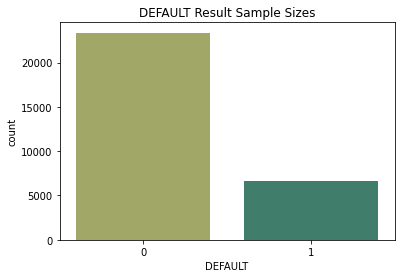

In [6]:
# Compare sample size for each binary result
sns.countplot(data=data, x='DEFAULT',palette='gist_earth_r')
plt.title("DEFAULT Result Sample Sizes")
plt.show()

# FIX with oversampling below

Based on the plot above, there is a heavy skew of non-defaulting (DEFAULT=0) data points. We will correct this by using oversampling on the default (DEFAULT=1).

In [7]:
# Oversampling
labels=data['DEFAULT']
dataDF=data.drop(['DEFAULT'], axis=1)
oversample=SMOTE(random_state=1234)
dxX, dyy = oversample.fit_resample(dataDF, labels)

In [8]:
data=dxX
data['DEFAULT']=dyy
data

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_SEPT,PAY_AUG,PAY_JUL,PAY_JUN,PAY_MAY,...,BILL_AMT_JUN,BILL_AMT_MAY,BILL_AMT_APR,PAY_AMT_SEP,PAY_AMT_AUG,PAY_AMT_JUL,PAY_AMT_JUN,PAY_AMT_MAY,PAY_AMT_APR,DEFAULT
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46723,10000,1,2,1,29,1,1,2,0,0,...,9307,10084,10119,2394,0,1018,918,338,0,1
46724,120000,2,1,2,25,0,-1,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,1
46725,150000,2,1,1,38,-1,-1,-2,-2,-2,...,0,0,1639,0,0,0,0,1639,10464,1
46726,50000,1,2,1,35,2,0,0,0,0,...,11919,2712,4951,1796,1446,1054,378,89,247,1


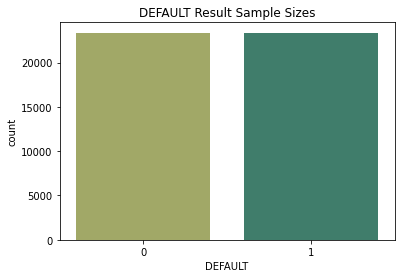

In [9]:
# Confirm oversampling functioned as normal
sns.countplot(data=data, x='DEFAULT',palette='gist_earth_r')
plt.title("DEFAULT Result Sample Sizes")
plt.show()

In [10]:
# Creating dictionaries to apply statistical functions to orginial data set for EDA
payDict={}
bilDict={}
pmtDict={}
cols=['SEX','EDUCATION','MARRIAGE','AGE','DEFAULT']
colDict={'EDUCATION':['value_counts'],
         'MARRIAGE':['value_counts'],
         'SEX':['value_counts'],
         'DEFAULT':['value_counts']}
for i in range(6):
    payDict[payHist[i]]=["mean","std","min","max"]
    bilDict[billMon[i]]=["mean","std","min","max"]
    pmtDict[paidMon[i]]=["mean","std","min","max"]

count    46728.000000
mean        35.411894
std          8.840663
min         21.000000
25%         28.000000
50%         34.000000
75%         41.000000
max         79.000000
Name: AGE, dtype: float64

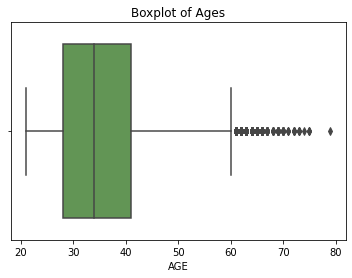

In [11]:
# Age data
sns.boxplot(data['AGE'], palette='gist_earth_r')
plt.title("Boxplot of Ages")
data['AGE'].describe()

In [12]:
# Catgegorical data summaries + Verify Default data oversampling counts
dfDataCols=data[cols].apply(colDict)
dfDataCols

,EDUCATION,MARRIAGE,SEX,DEFAULT
,value_counts,value_counts,value_counts,value_counts
0,14,70.0,NaN,23364.0
1,17967,25614.0,23102.0,23364.0
2,22622,20714.0,23626.0,NaN
3,5637,330.0,NaN,NaN
4,152,NaN,NaN,NaN
5,285,NaN,NaN,NaN
6,51,NaN,NaN,NaN


In [13]:
# Dictionary to neatly summarize value counts of payment status in each month
paymntdict={'PAY_SEPT':['value_counts'], 'PAY_AUG':['value_counts'], 'PAY_JUL':['value_counts'], 
            'PAY_JUN':['value_counts'], 'PAY_MAY':['value_counts'], 'PAY_APR':['value_counts']}
dfHist=data[payHist].apply(paymntdict)
dfHist

,PAY_SEPT,PAY_AUG,PAY_JUL,PAY_JUN,PAY_MAY,PAY_APR
,value_counts,value_counts,value_counts,value_counts,value_counts,value_counts
-2,3013,4791,5270,5645,5964,6466
-1,7637,8329,8240,8015,7818,8267
0,21829,22958,23452,24770,25727,24820
1,8149,2679,2470,2159,1962,1918
2,5348,7243,6628,5449,4577,4625
3,533,480,391,334,338,325
4,110,155,132,132,140,103
5,47,45,59,50,30,27
6,21,27,40,17,17,46


In [14]:
# Stats on payment history status
dfPayd=round(data[payHist].apply(payDict),2)
dfPayd

,PAY_SEPT,PAY_AUG,PAY_JUL,PAY_JUN,PAY_MAY,PAY_APR
mean,0.17,0.04,-0.01,-0.07,-0.12,-0.16
std,1.12,1.22,1.22,1.22,1.18,1.20
min,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00
max,8.00,8.00,8.00,8.00,8.00,8.00


In [15]:
# Stats on billed amount per month
dfBilld=round(data[billMon].apply(bilDict),2)
dfBilld

,BILL_AMT_SEP,BILL_AMT_AUG,BILL_AMT_JUL,BILL_AMT_JUN,BILL_AMT_MAY,BILL_AMT_APR
mean,50083.40,48406.62,46220.02,42703.22,39929.10,38689.27
std,73050.18,70930.46,68528.83,63880.98,60629.09,59359.21
min,-165580.00,-69777.00,-157264.00,-170000.00,-81334.00,-339603.00
max,964511.00,983931.00,1664089.00,891586.00,927171.00,961664.00


In [16]:
# Stats on paid amount per month
dfMonPaid=round(data[paidMon].apply(pmtDict),2)
dfMonPaid

,PAY_AMT_SEP,PAY_AMT_AUG,PAY_AMT_JUL,PAY_AMT_JUN,PAY_AMT_MAY,PAY_AMT_APR
mean,4746.69,4872.34,4447.29,4055.1,4096.86,4416.32
std,14055.35,19040.27,15605.35,13347.0,13350.95,15606.07
min,0.00,0.00,0.00,0.0,0.00,0.00
max,873552.00,1684259.00,896040.00,621000.0,426529.00,528666.00


In [17]:
# Settings adjustmnet
pd.set_option('display.max_columns',None)

In [18]:
# Create binned amounts to eliminate errors from source data + bin ages
binned=['MarriageBin','EducationBin','AgeBin']
marBin=[]
eduBin=[]
ageBin=[]
for i in range(len(data)):
    marr=data['MARRIAGE'][i]
    educ=data['EDUCATION'][i]
    ages=data['AGE'][i]
    if marr==0 or marr>3:
        marBin.append(3)
    else:
        marBin.append(marr)
    if educ>4 or educ==0:
        eduBin.append(4)
    else:
        eduBin.append(educ)
    if ages<=34:
        ageBin.append(1)
    elif ages>=35 and ages<=49:
        ageBin.append(2)
    elif ages>=50 and ages<=64:
        ageBin.append(3)
    else:
        ageBin.append(4)

        
data.insert(len(data.columns),"Marriage_Bin",marBin,True)
data.insert(len(data.columns),"Education_Bin",eduBin,True)
data.insert(len(data.columns),"Age_Bin",ageBin,True)

### Feature engineering

In [19]:
# Average bill amount and average payment made
billDF=[]
for i in range(len(data)):
    totalBill=0
    for j in billMon:
        totalBill+=data[j][i]
    avgBill=totalBill/6
    billDF.append(avgBill)
payDF=[]
for i in range(len(data)):
    totalPaid=0
    for j in paidMon:
        totalPaid+=data[j][i]
    avgPay=totalPaid/6
    payDF.append(avgPay)

data.insert(len(data.columns),"Avg_Bill_Amt",billDF,True)
data.insert(len(data.columns),"Avg_Pmt_Amt",payDF,True)

In [20]:
# Pay Ratio
payRatio = ('AugPayRat','JulPayRat','JunPayRat','MayPayRat','AprPayRat')
for i, j, l in zip(billMon[1:], payRatio, paidMon[:-1]):
    df=[]
    for k in range(len(data)):
        pay=data[l][k]
        bal=data[i][k]
        if pay==0 and bal==0:
            G=1
        elif pay!=0 and bal==0:
            G=1
        else:
            G=pay/bal
        df.append(G)
    data.insert(len(data.columns),j,df,True)

avgPRdf=[]
for i in range(len(data)):
    totalPR=0
    for j in payRatio:
        totalPR+=data[j][i]
    avgPR=totalPR/5
    avgPRdf.append(avgPR)
data.insert(len(data.columns),'Avg_Pmt_Ratio',avgPRdf,True)

In [21]:
# Utilization
monthlyUtilize = ('SeptUtil','AugUtil','JulUtil','JunUtil','MayUtil','AprUtil')
for i, j in zip(billMon, monthlyUtilize):
    df=[]
    for k in range(len(data)):
        df.append((data[i][k]/data['LIMIT_BAL'][k]))
    data.insert(len(data.columns),j,df,True)
utilDF=[]
for i in range(len(data)):
    totalUtil=0
    for j in monthlyUtilize:
        totalUtil+=data[j][i]
    avgUtil=totalUtil/6
    utilDF.append(avgUtil)
data.insert(len(data.columns),'Avg_Util',utilDF,True)

In [22]:
# 6 month growth
balGrow=[]
utilGrow=[]
for i in range(len(data)):
    septBill=data['BILL_AMT_SEP'][i]
    aprBill =data['BILL_AMT_APR'][i]
    if septBill==0 and aprBill==0:
        balGrow.append(1)
    elif septBill!=0 and aprBill==0:
        balGrow.append(septBill)
    else:
        balGrow.append((septBill-aprBill)/aprBill)
for i in range(len(data)):
    septUtil=data['SeptUtil'][i]
    aprUtil =data['AprUtil'][i]
    if septUtil==0 and aprUtil==0:
        utilGrow.append(1)
    elif septUtil!=0 and aprUtil==0:
        utilGrow.append(septUtil)
    else:
        utilGrow.append((septUtil-aprUtil)/aprUtil)
data.insert(len(data.columns),'Bal_Growth_6mo',balGrow,True)
data.insert(len(data.columns),'Util_Growth_6mo',utilGrow,True)

In [23]:
# Largest Bill
bigBill=data[billMon].max(axis=1)
data.insert(len(data.columns),'Max_Bill_Amt',bigBill,True)

In [24]:
# Largest Payment
bigPaid=data[paidMon].max(axis=1)
data.insert(len(data.columns),'Max_Pmt_Amt',bigPaid,True)

In [25]:
# Ratio between largest payment and bill
numerator=bigPaid
denominator=bigBill
X=[]
for num, den in zip(numerator, denominator):
    if num == 0 and den == 0:
        X.append(1)
    elif num != 0 and den == 0:
        X.append(num)
    else:
        X.append(num/den)
bigRatio=X
data.insert(len(data.columns),'Max_Ratio',bigRatio,True)

In [26]:
# Max delinquency of payment
maxDLQ=data[payHist].max(axis=1)
for i in range(len(maxDLQ)):
    if maxDLQ[i]<0:
        maxDLQ[i]=0
data.insert(len(data.columns),'Max_DLQ',maxDLQ,True)

In [27]:
# Utilization change
crntUtil=data['SeptUtil']
utils=['SeptUtil','AugUtil','JulUtil','JunUtil','MayUtil','AprUtil',]
minUtil=data[utils].min(axis=1)
utilDelta=crntUtil-minUtil
data.insert(len(data.columns),'Util_Delta',utilDelta,True)

In [28]:
# sept bill-bal limit
debt=data['LIMIT_BAL']-data['BILL_AMT_SEP']
data.insert(len(data.columns),'Amt_Left',debt,True)

# Split into train,test,validate

In [29]:
random.seed(1234)
train=[]
test=[]
validate=[]
for i in range(len(data)):
    x=random.random()
    if x<.7:
        train.append(1)
        test.append(0)
        validate.append(0)
    elif x>=.7 and x<.9:
        train.append(0)
        test.append(1)
        validate.append(0)
    else:
        train.append(0)
        test.append(0)
        validate.append(1)
data.insert(len(data.columns),'train',train,True)
data.insert(len(data.columns),'test',test,True)
data.insert(len(data.columns),'validate',validate,True)

In [30]:
# Subset percent split
hdrs=['train','test','validate']
x=[]
for i in hdrs:
    x.append(round((data[i]==1).sum()/len(data)*100,4))
mydata=[[hdrs],[x]]
print(tabulate(mydata))

-----------------------------
['train', 'test', 'validate']
[70.11, 19.9302, 9.9598]
-----------------------------


In [31]:
## Split data sets
train=data[data['train']==1]
test=data[data['test']==1]
validate=data[data['validate']==1]

## drop test, train, validate  variables
train=train.drop(['AGE','EDUCATION','MARRIAGE','train','test','validate'],axis=1)
test=test.drop(['AGE','EDUCATION','MARRIAGE','train','test','validate'],axis=1)
validate=validate.drop(['AGE','EDUCATION','MARRIAGE','train','test','validate'],axis=1)

In [32]:
# pop Default
colList=payHist+billMon+paidMon
trainDefault=train['DEFAULT']
train=train.drop(columns=colList)
testDefault=test['DEFAULT']
test=test.drop(columns=colList)
validateDefault=validate['DEFAULT']
validate=validate.drop(columns=colList)

# Traditional EDA

In [33]:
# Repeatable bar plot function for EDA
def barstack(X):
    varName=[X,"DEFAULT"]
    df=train[varName]
    plot=sns.countplot(data=df,x=X,hue='DEFAULT',palette='gist_earth_r')
    plt.title(X+' Stacked Barplot')
    return plot

In [34]:
# Repeatable box plot function for EDA
def edaBox(X,lm=(None,None)):
    plot=sns.boxplot(data=train,y=X,x="DEFAULT", hue="DEFAULT",palette='gist_earth_r')
    plt.ylim(lm)
    plt.title(X+' Box Plot')
    return plot

In [35]:
# Repeatable stats table function for EDA
def stats(X):
    df0=train[train["DEFAULT"]==0]
    df1=train[train["DEFAULT"]==1]
    head=['Default','Mean','STD','Median','Min','Max']
    ddf0={"Default":0,
          "Mean": np.mean(df0[X]),
          "STD" : np.std(df0[X]),
          "Median" : np.median(df0[X]),
          "Min" : np.min(df0[X]),
          "Max" : np.max(df0[X])}
    ddf1={"Default":1,
          "Mean": np.mean(df1[X]),
          "STD" : np.std(df1[X]),
          "Median" : np.median(df1[X]),
          "Min" : np.min(df1[X]),
          "Max" : np.max(df1[X])}
    df=pd.DataFrame(data=[ddf0,ddf1])
    tbl=df
    print(tabulate(df,headers=head,tablefmt='grid',floatfmt=".2f"))
    return tbl
    # mean, std, median, min, max, PER DEFAULT SCORE

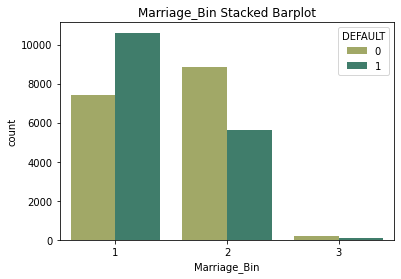

In [36]:
marBin=barstack('Marriage_Bin')

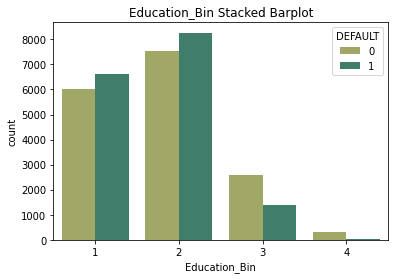

In [37]:
eduBin=barstack('Education_Bin')

In [38]:
# 6 month Balance growth stats tables by default status
BG6=stats('Bal_Growth_6mo')

+----+-----------+---------+----------+----------+------------+-----------+
|    |   Default |    Mean |      STD |   Median |        Min |       Max |
+====+===========+=========+==========+==========+============+===========+
|  0 |      0.00 | 2344.29 | 15049.46 |     0.22 | -108098.00 | 388897.00 |
+----+-----------+---------+----------+----------+------------+-----------+
|  1 |      1.00 | 1112.86 |  9504.55 |     0.00 |  -31250.93 | 279846.00 |
+----+-----------+---------+----------+----------+------------+-----------+


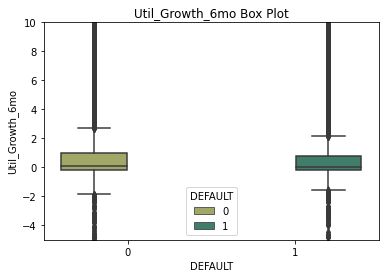

In [39]:
# Utilization growth over 6 months by default status
UtilGrow6=edaBox('Util_Growth_6mo', (-5,10))

In [40]:
# Utilization growth over 6 months by default status (Stats table)
UG6=stats('Util_Growth_6mo')

+----+-----------+--------+---------+----------+------------+----------+
|    |   Default |   Mean |     STD |   Median |        Min |      Max |
+====+===========+========+=========+==========+============+==========+
|  0 |      0.00 | -30.66 | 1274.75 |     0.09 | -108098.00 | 15678.00 |
+----+-----------+--------+---------+----------+------------+----------+
|  1 |      1.00 |  -3.52 |  357.95 |     0.00 |  -31250.93 |  4940.00 |
+----+-----------+--------+---------+----------+------------+----------+


In [41]:
# Average payment ratio stats table 
APR=stats("Avg_Pmt_Ratio")

+----+-----------+--------+--------+----------+-----------+---------+
|    |   Default |   Mean |    STD |   Median |       Min |     Max |
+====+===========+========+========+==========+===========+=========+
|  0 |      0.00 |  -0.64 | 128.63 |     0.23 | -16429.80 | 1005.40 |
+----+-----------+--------+--------+----------+-----------+---------+
|  1 |      1.00 |   0.27 |   6.55 |     0.07 |   -788.56 |  138.41 |
+----+-----------+--------+--------+----------+-----------+---------+


In [42]:
# Average payment amount stats table
APA=stats("Avg_Pmt_Amt")

+----+-----------+---------+----------+----------+-------+-----------+
|    |   Default |    Mean |      STD |   Median |   Min |       Max |
+====+===========+=========+==========+==========+=======+===========+
|  0 |      0.00 | 5695.08 | 10066.45 |  2708.00 |  0.00 | 385692.00 |
+----+-----------+---------+----------+----------+-------+-----------+
|  1 |      1.00 | 3048.89 |  5315.46 |  1555.00 |  0.00 | 117368.00 |
+----+-----------+---------+----------+----------+-------+-----------+


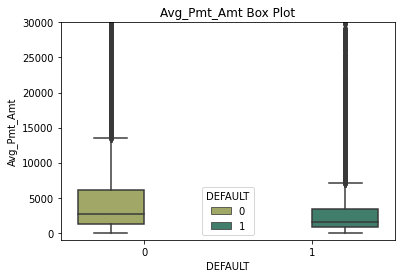

In [43]:
# Average payment amount box plot by default status
APAplt=edaBox("Avg_Pmt_Amt",(-1000,30000))

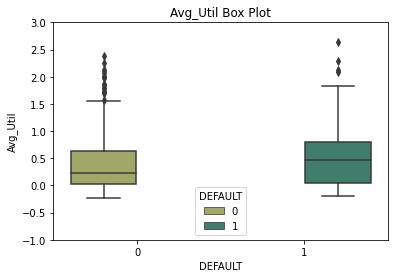

In [44]:
# Average utilization by default status box plot
AvgUtil=edaBox("Avg_Util",(-1,3))

In [45]:
# Average utilization stats table
AVGutil=stats("Avg_Util")

+----+-----------+--------+-------+----------+-------+-------+
|    |   Default |   Mean |   STD |   Median |   Min |   Max |
+====+===========+========+=======+==========+=======+=======+
|  0 |      0.00 |   0.35 |  0.34 |     0.24 | -0.23 |  2.39 |
+----+-----------+--------+-------+----------+-------+-------+
|  1 |      1.00 |   0.45 |  0.37 |     0.46 | -0.20 |  2.64 |
+----+-----------+--------+-------+----------+-------+-------+


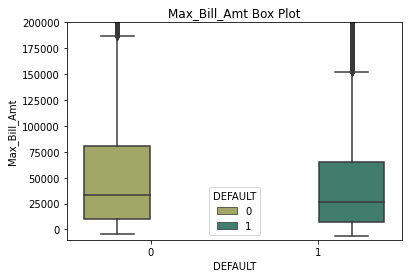

In [46]:
# Largest bill amount box plot
MBA=edaBox("Max_Bill_Amt",(-10000,200000))

In [47]:
# Largest bill amount stats table 
MBAstat=stats("Max_Bill_Amt")

+----+-----------+----------+----------+----------+----------+------------+
|    |   Default |     Mean |      STD |   Median |      Min |        Max |
+====+===========+==========+==========+==========+==========+============+
|  0 |      0.00 | 61290.82 | 77680.24 | 33290.00 | -4300.00 | 1664089.00 |
+----+-----------+----------+----------+----------+----------+------------+
|  1 |      1.00 | 53125.24 | 74194.18 | 26399.00 | -6029.00 |  610723.00 |
+----+-----------+----------+----------+----------+----------+------------+


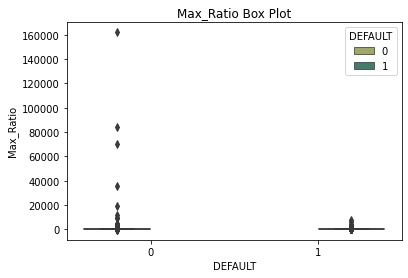

In [48]:
# Max bill/max paid ratio box plot
mxRat=edaBox('Max_Ratio')

In [49]:
# Max bill/max paid ratio box plot
MXR=stats('Max_Ratio')

+----+-----------+--------+---------+----------+---------+-----------+
|    |   Default |   Mean |     STD |   Median |     Min |       Max |
+====+===========+========+=========+==========+=========+===========+
|  0 |      0.00 |  28.74 | 1566.48 |     0.21 | -470.00 | 162000.00 |
+----+-----------+--------+---------+----------+---------+-----------+
|  1 |      1.00 |   3.56 |  101.92 |     0.12 | -117.78 |   7700.00 |
+----+-----------+--------+---------+----------+---------+-----------+


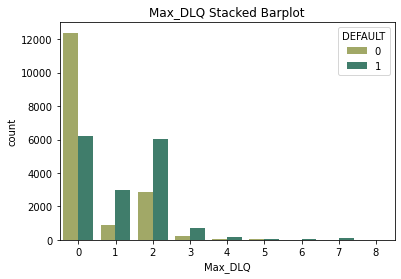

In [50]:
# Max delinquency bar plot
mDLQ=barstack('Max_DLQ')

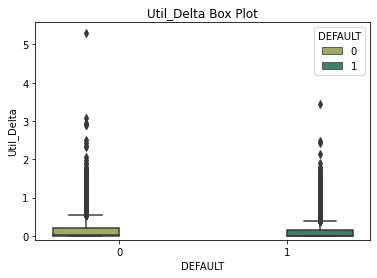

In [51]:
# Change in utilization box plot
uDelta=edaBox('Util_Delta',(-0.1,None))

In [52]:
# Change in utilization stats table
utilDelta=stats('Util_Delta')

+----+-----------+--------+-------+----------+-------+-------+
|    |   Default |   Mean |   STD |   Median |   Min |   Max |
+====+===========+========+=======+==========+=======+=======+
|  0 |      0.00 |   0.16 |  0.27 |     0.03 |  0.00 |  5.31 |
+----+-----------+--------+-------+----------+-------+-------+
|  1 |      1.00 |   0.14 |  0.26 |     0.01 |  0.00 |  3.44 |
+----+-----------+--------+-------+----------+-------+-------+


In [53]:
# Balance remaining after 6 months stats table
amtLeft=stats('Amt_Left')

+----+-----------+-----------+-----------+----------+------------+-----------+
|    |   Default |      Mean |       STD |   Median |        Min |       Max |
+====+===========+===========+===========+==========+============+===========+
|  0 |      0.00 | 126670.90 | 132412.38 | 82152.00 | -302827.00 | 793771.00 |
+----+-----------+-----------+-----------+----------+------------+-----------+
|  1 |      1.00 |  79674.24 | 109529.32 | 28846.00 | -249654.00 | 739040.00 |
+----+-----------+-----------+-----------+----------+------------+-----------+


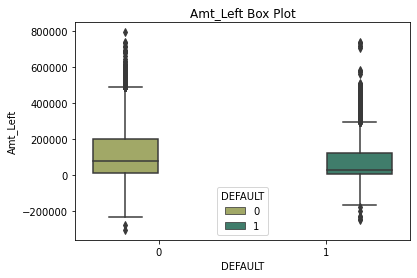

In [54]:
# Balance remaining box plot
AL=edaBox('Amt_Left')

## Model Based EDA

The first selection method is using all features. The second will be using a combination of information value (IV)
and weight of evidence (WOE) to pick the strongest variables with little to no co-dependency. The third way is the
using a decision tree grid search that randomly picks variables to narrow down the variables to be used.

In [55]:
# Function to calculate IV and WOE
def iv_woe(data, target, bins=10, show_woe=False):
    
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    cols = data.columns
    for i in cols[~cols.isin([target])]:
        if (data[i].dtype.kind in 'bifc') and (len(np.unique(data[i]))>15):
            binned_x=pd.qcut(data[i], bins, duplicates='drop')
            d0=pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0=pd.DataFrame({'x': data[i], 'y': data[target]})
        d=d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns=['Cutoff', 'N', 'Events']
        d['% of Events']=np.maximum(d['Events'], 0.5)/d['Events'].sum()
        d['Non-Events']=d['N']-d['Events']
        d['% of Non-Events']=np.maximum(d['Non-Events'], 0.5)/d['Non-Events'].sum()
        d['WoE']=np.log(d['% of Events']/d['% of Non-Events'])
        d['IV']=d['WoE']*(d['% of Events']-d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=i)
        #print("Information value of "+i+" is "+str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [i], "IV" : [d['IV'].sum()]}, columns=["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)
        if show_woe == True:
            print(d)
    return newDF, woeDF

In [56]:
iv, woe = iv_woe(train, target='DEFAULT', bins=4,show_woe=False)

In [57]:
# Eliminate high IV, high IV could lead to overfitting
ivLow=iv[iv.IV>0.08]
woeList=list(ivLow.Variable)
woeList.append('DEFAULT')
print(woeList)

['LIMIT_BAL', 'SEX', 'Marriage_Bin', 'Education_Bin', 'Avg_Pmt_Amt', 'AugPayRat', 'JulPayRat', 'Avg_Pmt_Ratio', 'AugUtil', 'JulUtil', 'JunUtil', 'MayUtil', 'AprUtil', 'Avg_Util', 'Bal_Growth_6mo', 'Max_Pmt_Amt', 'Max_Ratio', 'Max_DLQ', 'Amt_Left', 'DEFAULT']


Fitting 10 folds for each of 280 candidates, totalling 2800 fits


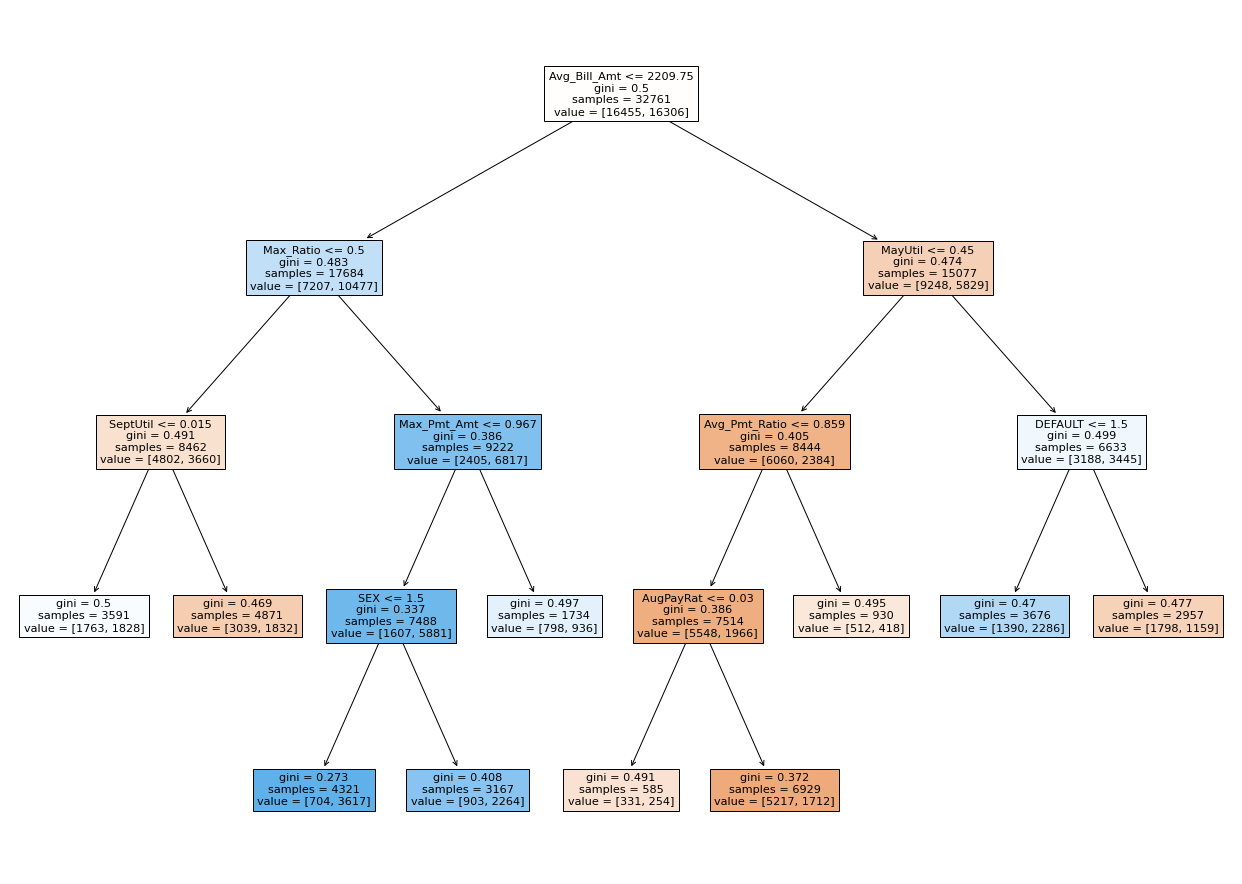

In [58]:
# Decision Tree
dtcDF=data.copy(deep=True)
dtcY=dtcDF.pop('DEFAULT')
dtcDF.pop('train')
dtcDF.pop('test')
dtcDF.pop('validate')
warnings.simplefilter(action='ignore', category=FutureWarning)
params={"criterion":['gini','entropy'],"splitter":['best'],"max_depth":range(3,10),
        "min_samples_split": range(5000,15000,1000), "max_features":['sqrt','log2']}
clfDT=DecisionTreeClassifier(random_state=1234)
clf_dt=GridSearchCV(clfDT,param_grid=params, cv=10,scoring='accuracy',verbose=1,n_jobs=-1)
clf_dt.fit(dtcDF,dtcY)
locals().update(clf_dt.best_params_)
clf=DecisionTreeClassifier(criterion=criterion,splitter=splitter,max_depth=max_depth,
                           min_samples_split=min_samples_split,max_features=max_features,random_state=1234)
trainDF=train.copy(deep=True)
trainDF.pop('DEFAULT')
clf.fit(trainDF,trainDefault)
plt.figure(figsize=(22,16))
plot_tree(clf,feature_names=list(train.columns),filled=True)
plt.savefig('DecisionTree')
plt.show()

In [59]:
ftImport=clf.feature_importances_
ftList=clf.feature_names_in_
dtcFeats=ftList[ftImport>0]
dtcFeats=list(dtcFeats)
dtcFeats.append('DEFAULT')
print(dtcFeats)

['SEX', 'Marriage_Bin', 'Avg_Pmt_Amt', 'JulPayRat', 'SeptUtil', 'AugUtil', 'AprUtil', 'Max_Ratio', 'Max_DLQ', 'DEFAULT']


## OneR classifier

OneR, short for "One Rule", is a classification method that selects one rule which yields the 
smallest total error. This will show how accurate each variable selection method is.

In [60]:
def get_feature_quartiles(X,lst,t=False):
    X=X.drop(["DEFAULT"], axis=1)
    if t == True:
        X=X[lst]
    X_discretized = X.copy()
    X_discretized=X_discretized.to_numpy()
    for col in range(X.shape[1]):
        for q, class_label in zip([1.0, 0.75, 0.5, 0.25], [3, 2, 1, 0]):
            threshold = np.quantile(X.iloc[:, col], q=q)
            X_discretized[X.iloc[:, col] <= threshold, col] = class_label
    return X_discretized.astype(np.int)

In [61]:
## All Features
train_disc=get_feature_quartiles(train,0)
oner=OneRClassifier()
oner.fit(train_disc,trainDefault)
ytrainOneR=oner.predict(train_disc)
train_acc = np.mean(ytrainOneR == trainDefault)  
print(f'Training accuracy {train_acc*100:.3f}%')
testDisc=get_feature_quartiles(test,0)
yOneRPred=oner.predict(testDisc)
OneRAcc=np.mean(yOneRPred == testDefault)  
print(f'Test accuracy {OneRAcc*100:.3f}%')

Training accuracy 68.557%
Test accuracy 68.936%


In [62]:
## WOE features
ftList=woeList.copy()
ftList.remove('DEFAULT')
train_disc=get_feature_quartiles(train,ftList,True)
oner=OneRClassifier()
oner.fit(train_disc,trainDefault)
ytrainOneR=oner.predict(train_disc)
train_acc = np.mean(ytrainOneR == trainDefault)  
print(f'Training accuracy {train_acc*100:.3f}%')
testDisc=get_feature_quartiles(test,ftList,True)
yOneRPred=oner.predict(testDisc)
OneRAcc=np.mean(yOneRPred == testDefault)  
print(f'Test accuracy {OneRAcc*100:.3f}%')

Training accuracy 68.557%
Test accuracy 68.936%


In [63]:
## Decision Tree features
ftList=dtcFeats.copy()
ftList.remove('DEFAULT')
train_disc=get_feature_quartiles(train,ftList,True)
oner=OneRClassifier()
oner.fit(train_disc,trainDefault)
ytrainOneR=oner.predict(train_disc)
train_acc = np.mean(ytrainOneR == trainDefault)  
print(f'Training accuracy {train_acc*100:.3f}%')
testDisc=get_feature_quartiles(test,ftList,True)
yOneRPred=oner.predict(testDisc)
OneRAcc=np.mean(yOneRPred == testDefault)  
print(f'Test accuracy {OneRAcc*100:.3f}%')

Training accuracy 68.557%
Test accuracy 68.936%


# Random Forest, Logistic, Gradient Boosted Trees, SVM

In [64]:
def training_models(Parameters, Model, DFtrain, DFtest, Modelname):
    start=datetime.now()
    datatrain=DFtrain.copy()
    X_train=datatrain.drop('DEFAULT',axis=1)
    y_train=datatrain['DEFAULT']
    datatest=DFtest.copy()
    X_test=datatest.drop('DEFAULT',axis=1)
    y_test=datatest['DEFAULT']
    sf = StratifiedKFold(n_splits=5, random_state=1234, shuffle=True)
    for i, j in sf.split(X_train, y_train):
        sf_x_train, sf_y_train = X_train.iloc[i], y_train.iloc[i]
        
    for i,j in sf.split(X_test,y_test):
        sf_x_test, sf_y_test = X_test.iloc[j], y_test.iloc[j]
    sf_x_train, sf_x_test, sf_y_train, sf_y_test = sf_x_train.values, sf_x_test.values, sf_y_train.values, sf_y_test.values
    mdl_params = Parameters
    mdl_keys = Parameters.keys()
    rndm_modl=RandomizedSearchCV(Model, mdl_params, n_iter=4, random_state=1234)
    beep.beep(1)
    for i, j in sf.split(sf_x_train,sf_y_train):
        pipe=imbalanced_make_pipeline(SMOTE(sampling_strategy='minority', random_state=1234), rndm_modl)
        fittingModel = pipe.fit(sf_x_train[i],sf_y_train[i])
        best_model=rndm_modl.best_estimator_
    sm=SMOTE(sampling_strategy='minority',random_state=1234)
    smx_train, smy_train = sm.fit_resample(sf_x_train, sf_y_train)
    beep.beep(1)
    final_mdl = rndm_modl.best_estimator_
    final_params = best_model.get_params()
    final_mdl.fit(smx_train, smy_train)
    
    y_trainPred=final_mdl.predict(X_train)
    model={}
    model['Model Type'] = Modelname
    model['Accuracy (Train)'] = round((accuracy_score(y_train, y_trainPred)*100),2)
    model['Precision (Train)'] = round(precision_score(y_train,y_trainPred),2)
    model['Recall (Train)'] = round(recall_score(y_train,y_trainPred),2)
    model['ROC-AUC Score (Train)'] = round(roc_auc_score(y_train, y_trainPred),2)
    cm=confusion_matrix(y_true=y_train, y_pred=y_trainPred)
    CMD=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_mdl.classes_)
    model['False Positive Rate (Train)']=round(cm[0,1]/(cm[0,1]+cm[0,0]),2)
    y_prediction=final_mdl.predict(X_test)
    used_params={}
    for i,j in Parameters.items():
        for k,l in final_params.items():
            if i==k:
                used_params[i] = l
    
    model['Accuracy (Test)'] = str(round((accuracy_score(y_test, y_prediction)*100),2)) + "%"
    model['Precision (Test)'] = round(precision_score(y_test,y_prediction),2)
    model['Recall (Test)'] = round(recall_score(y_test,y_prediction),2)
    model['ROC-AUC Score (Test)'] = round(roc_auc_score(y_test, y_prediction),2)
    cm=confusion_matrix(y_true=y_test, y_pred=y_prediction)
    cm=cm/cm.astype(np.float32).sum(axis=1)
    CMD=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_mdl.classes_)
    CMD.plot(cmap='gist_earth')
    model['False Positive Rate (Test)']=round(cm[0,1]/(cm[0,1]+cm[0,0]),2)
    stop=datetime.now()
    print("Function Run Time : ", (stop-start))
    beep.beep(4)
    return model, final_mdl, CMD

In [65]:
def importancePlot(Model, lst=None, check=False):
    DF=train.copy()
    if check==True:
        DF=DF[lst]
    DF.pop('DEFAULT')
    importances=Model.feature_importances_
    feature_importance=100*(importances/importances.max())
    feat_importances=pd.Series(feature_importance, index=DF.columns)
    sorted_idx=np.argsort(importances)
    Y=feat_importances.nlargest(10)
    X=Y.index
    sns.set_color_codes("muted")
    graph=sns.barplot(y=X,x=Y,color='b')
    return graph

# Random Forest

All features

Function Run Time :  0:03:05.578488


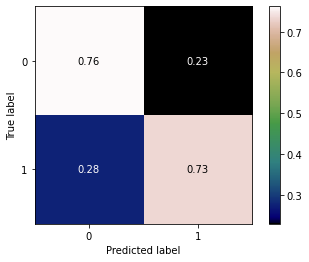

In [66]:
mdlName='Random Forest (All features)'
params={"criterion":['entropy','gini'],"max_depth":[2,3,4,5], 
        "min_samples_split": [500,1000,2500,5000],'max_features':['auto','sqrt','log2']}
RFCall, RFCmodel, RFCallCMD = training_models(params, RandomForestClassifier(random_state=1234),train, test, mdlName)

Text(0.5, 1.0, 'Random Forest (All features)')

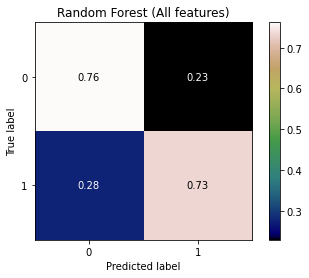

In [67]:
RFCallCMD.plot(cmap='gist_earth')
plt.title('Random Forest (All features)')

Text(0.5, 0, 'Percentage of Importance')

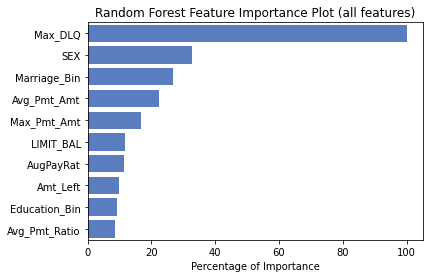

In [68]:
RFCallIP=importancePlot(RFCmodel)
RFCallIP.set_title('Random Forest Feature Importance Plot (all features)')
RFCallIP.set_xlabel('Percentage of Importance')

-----
WOE selected features

Function Run Time :  0:02:31.343863


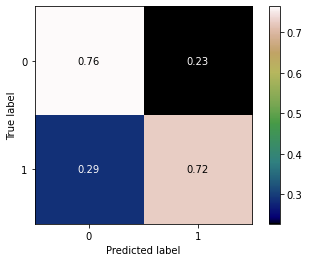

In [69]:
mdlName='Random Forest (WOE selected features)'
params={"criterion":['entropy','gini'],"max_depth":[2,3,4,5], 
        "min_samples_split": [500,1000,2500,5000],'max_features':['auto','sqrt','log2']}
RFCselectWOE, RFCmodelWOESelect, RFC_WoE_CMD=training_models(params, RandomForestClassifier(random_state=1234),train[woeList], test[woeList], mdlName)

Text(0.5, 1.0, 'Random Forest (WoE features)')

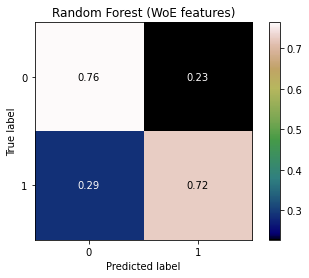

In [70]:
RFC_WoE_CMD.plot(cmap='gist_earth')
plt.title('Random Forest (WoE features)')

Text(0.5, 0, 'Percentage of Importance')

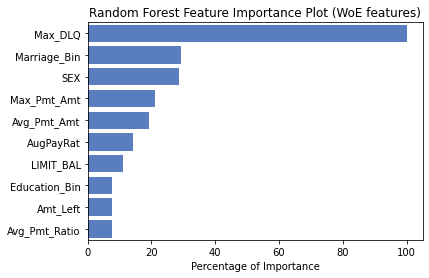

In [71]:
RFCWoEIP=importancePlot(RFCmodelWOESelect, woeList, True)
RFCWoEIP.set_title('Random Forest Feature Importance Plot (WoE features)')
RFCWoEIP.set_xlabel('Percentage of Importance')

-------
Decision Tree selected features

Function Run Time :  0:01:47.328159


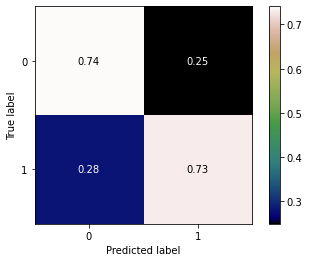

In [72]:
mdlName='Random Forest (Decision Tree selected features)'
params={"criterion":['entropy','gini'],"max_depth":[2,3,4,5], 
        "min_samples_split": [500,1000,2500,5000],'max_features':['auto','sqrt','log2']}
RFCselectdtc, RFCmodelDTCSelect, RFC_DTC_CMD=training_models(params, RandomForestClassifier(random_state=1234),train[dtcFeats], test[dtcFeats], mdlName)

Text(0.5, 1.0, 'Random Forest (Decision Tree features)')

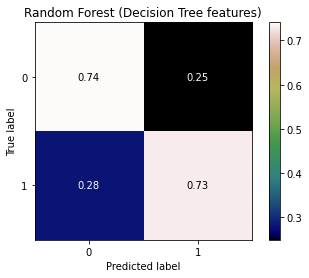

In [73]:
RFC_DTC_CMD.plot(cmap='gist_earth')
plt.title('Random Forest (Decision Tree features)')

Text(0.5, 0, 'Percentage of Importance')

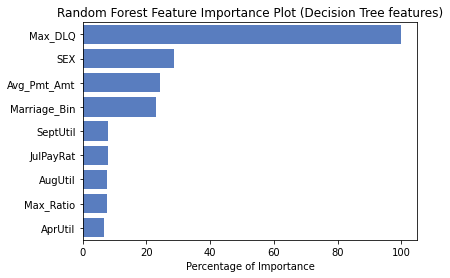

In [74]:
RFC_DTC_IP=importancePlot(RFCmodelDTCSelect, dtcFeats, True)
RFC_DTC_IP.set_title('Random Forest Feature Importance Plot (Decision Tree features)')
RFC_DTC_IP.set_xlabel('Percentage of Importance')

# Gradient Boosting

All features

Function Run Time :  0:09:25.035687


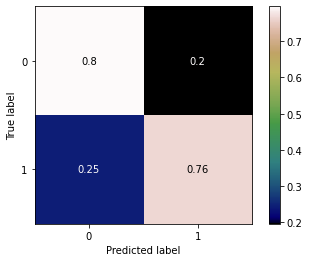

In [75]:
mdlName='Gradient Boosting (All features)'
params={"criterion":['friedman_mse', 'squared_error'],"max_depth":[2,3,4], 'learning_rate':[0.01,0.1,0.5],
        "min_samples_split": [1000,2500,5000],'max_features':['auto','sqrt','log2']}
GBMall, GBallModel, GBallCMD =training_models(params,GradientBoostingClassifier(random_state=1234),train, test, mdlName)

Text(0.5, 1.0, 'Gradient Boosting (All features)')

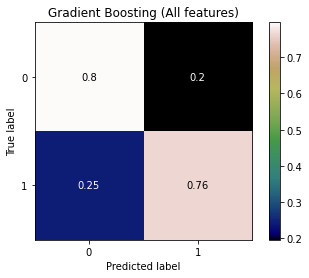

In [76]:
GBallCMD.plot(cmap='gist_earth')
plt.title('Gradient Boosting (All features)')

Text(0.5, 0, 'Percentage of Importance')

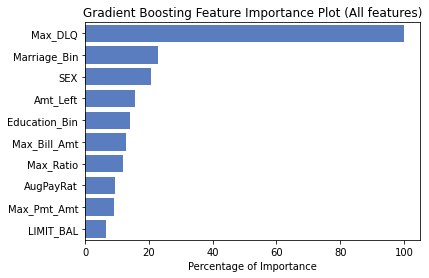

In [77]:
GBallIP=importancePlot(GBallModel)
GBallIP.set_title('Gradient Boosting Feature Importance Plot (All features)')
GBallIP.set_xlabel('Percentage of Importance')

-----
WOE selected features

Function Run Time :  0:06:24.472249


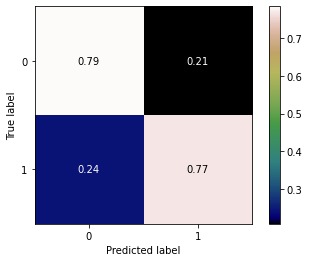

In [78]:
mdlName='Gradient Boosting (WOE selected features)'
params={"criterion":['friedman_mse', 'squared_error'],"max_depth":[2,3,4], 'learning_rate':[0.01,0.1,0.5],
        "min_samples_split": [1000,2500,5000],'max_features':['auto','sqrt','log2']}
GBMselectWOE, GBselectWOEModel, GBwoeCMD=training_models(params,GradientBoostingClassifier(random_state=1234),
                          train[woeList], test[woeList], mdlName)

Text(0.5, 1.0, 'Gradient Boosting (WoE features)')

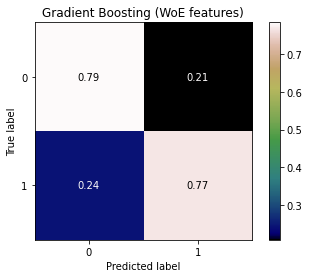

In [79]:
GBwoeCMD.plot(cmap='gist_earth')
plt.title('Gradient Boosting (WoE features)')

Text(0.5, 0, 'Percentage of Importance')

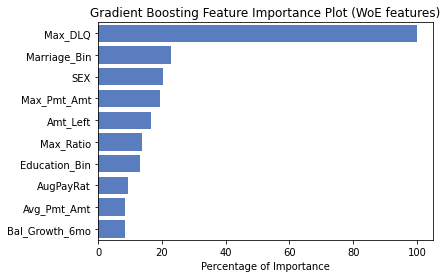

In [80]:
GBwoeIP=importancePlot(GBselectWOEModel, woeList, True)
GBwoeIP.set_title('Gradient Boosting Feature Importance Plot (WoE features)')
GBwoeIP.set_xlabel('Percentage of Importance')

-----
Decision Tree selected features

Function Run Time :  0:03:10.947147


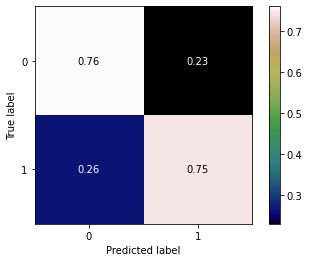

In [81]:
mdlName='Gradient Boosting (Decision Tree selected features)'
params={"criterion":['friedman_mse', 'squared_error'],"max_depth":[2,3,4], 'learning_rate':[0.01,0.1,0.5],
        "min_samples_split": [1000,2500,5000],'max_features':['auto','sqrt','log2']}
GBMselectDTC, GBselectDTCModel, GBdtcCMD=training_models(params,GradientBoostingClassifier(random_state=1234),
                          train[dtcFeats], test[dtcFeats], mdlName)

Text(0.5, 1.0, 'Gradient Boosting (Decision Tree features)')

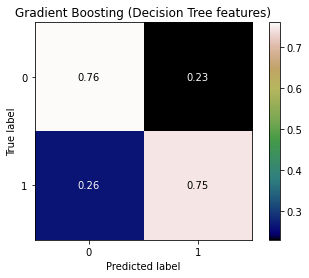

In [82]:
GBdtcCMD.plot(cmap='gist_earth')
plt.title('Gradient Boosting (Decision Tree features)')

Text(0.5, 0, 'Percentage of Importance')

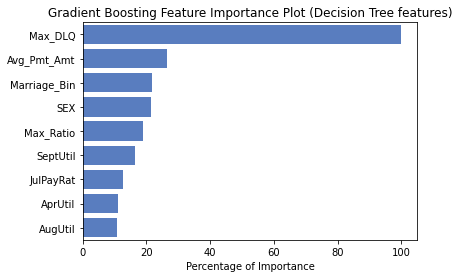

In [83]:
GBdtcIP=importancePlot(GBselectDTCModel, dtcFeats, True)
GBdtcIP.set_title('Gradient Boosting Feature Importance Plot (Decision Tree features)')
GBdtcIP.set_xlabel('Percentage of Importance')

# Logistic Regression

All features

Function Run Time :  0:00:15.326394


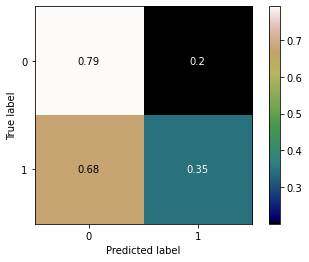

In [84]:
mdlName='Logistic Regression (All features)'
params={'solver': ['lbfgs','newton-cg','saga'],'penalty':['l1','l2','elasticnet']}
LOGall, LOGmodelAll, LOGallCMD=training_models(params, LogisticRegression(random_state=1234),train, test, mdlName)

Text(0.5, 1.0, 'Logistic Regression (All features)')

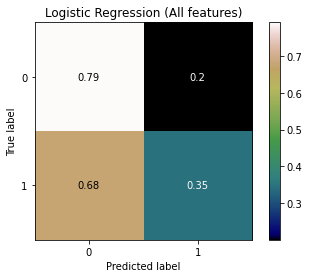

In [85]:
LOGallCMD.plot(cmap='gist_earth')
plt.title('Logistic Regression (All features)')

In [86]:
# OLS Regression results
X=train.copy(deep=True)
X.pop('DEFAULT')
y=trainDefault.copy()
lg=sm.OLS(y,X)
result=lg.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                DEFAULT   R-squared (uncentered):                   0.534
Model:                            OLS   Adj. R-squared (uncentered):              0.534
Method:                 Least Squares   F-statistic:                              1443.
Date:                Sat, 12 Aug 2023   Prob (F-statistic):                        0.00
Time:                        13:45:53   Log-Likelihood:                         -22550.
No. Observations:               32761   AIC:                                  4.515e+04
Df Residuals:                   32735   BIC:                                  4.537e+04
Df Model:                          26                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

-----
ETC selected features

For logistic regression, WOE selection was replaced with Extra Trees classification as WOE did not produce enough
unique features.

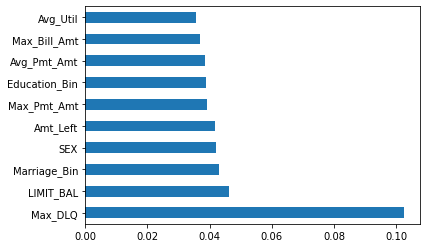

In [87]:
# Extra Trees Classification
X=train.copy()
Y=X['DEFAULT']
X.pop('DEFAULT')
Y=Y.values
model=ExtraTreesClassifier(n_estimators=10)
model.fit(X,Y)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
ETCfeats=(feat_importances.nlargest(10).index)
ETCfeats=list(ETCfeats)
ETCfeats+=['DEFAULT']
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

Function Run Time :  0:00:08.396868


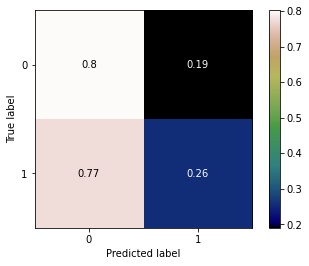

In [88]:
mdlName='Logistic Regression (ETC features)'
params={'solver': ['lbfgs','newton-cg','saga'],'penalty':['l1','l2','elasticnet']}
LOGselectETC, LOGETCmodel, LOGetcCMD=training_models(params, LogisticRegression(random_state=1234),train[ETCfeats], test[ETCfeats], mdlName)

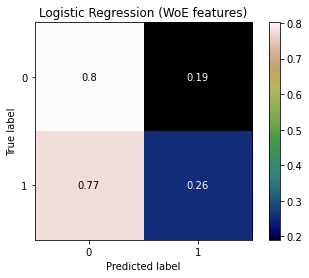

In [89]:
LOGetcCMD.plot(cmap='gist_earth')
plt.title('Logistic Regression (WoE features)')
plt.savefig('Log_WoE_CMD')

In [90]:
X=train.copy(deep=True)
X=X[ETCfeats]
X.pop('DEFAULT')
y=trainDefault.copy()
lg=sm.OLS(y,X)
result=lg.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                DEFAULT   R-squared (uncentered):                   0.518
Model:                            OLS   Adj. R-squared (uncentered):              0.518
Method:                 Least Squares   F-statistic:                              3527.
Date:                Sat, 12 Aug 2023   Prob (F-statistic):                        0.00
Time:                        13:46:06   Log-Likelihood:                         -23085.
No. Observations:               32761   AIC:                                  4.619e+04
Df Residuals:                   32751   BIC:                                  4.627e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

----
Decision Tree selected features

Function Run Time :  0:00:07.924003


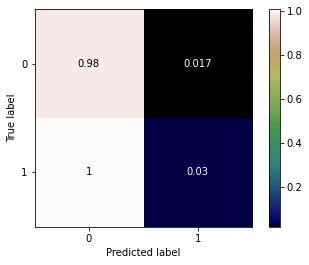

In [91]:
mdlName='Logistic Regression (Decision tree selected features)'
params={'solver': ['lbfgs','newton-cg','saga'],'penalty':['l1','l2','elasticnet']}
LOGselectDTC, LOGDTCmodel, LOGdtcCMD=training_models(params, LogisticRegression(random_state=1234),train[dtcFeats], test[dtcFeats], mdlName)

Text(0.5, 1.0, 'Logistic Regression (Decision Tree features)')

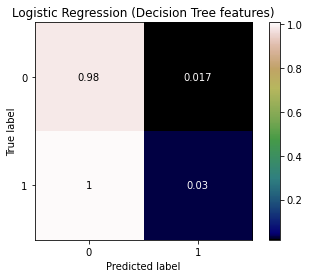

In [92]:
LOGdtcCMD.plot(cmap='gist_earth')
plt.title('Logistic Regression (Decision Tree features)')

In [93]:
X=train.copy(deep=True)
X=X[dtcFeats]
X.pop('DEFAULT')
y=trainDefault.copy()
lg=sm.OLS(y,X)
result=lg.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                DEFAULT   R-squared (uncentered):                   0.508
Model:                            OLS   Adj. R-squared (uncentered):              0.508
Method:                 Least Squares   F-statistic:                              3755.
Date:                Sat, 12 Aug 2023   Prob (F-statistic):                        0.00
Time:                        13:46:18   Log-Likelihood:                         -23444.
No. Observations:               32761   AIC:                                  4.691e+04
Df Residuals:                   32752   BIC:                                  4.698e+04
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

# SVM

All features

Function Run Time :  0:14:00.436375


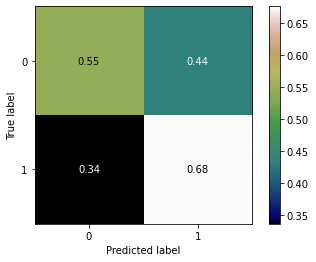

In [94]:
mdlName='SVM (All Features)'
params={'degree':[3], 'max_iter' : [-1]}
SVMall, SVMallModel, SVMallCMD =training_models(params,SVC(random_state=1234),train, test, mdlName)

Text(0.5, 1.0, 'SVM (All features)')

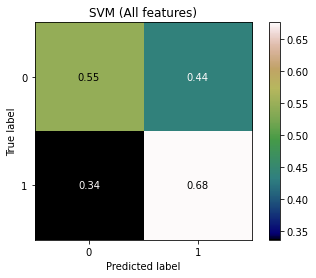

In [95]:
SVMallCMD.plot(cmap='gist_earth')
plt.title('SVM (All features)')

------
WOE selected features

Function Run Time :  0:13:38.902419


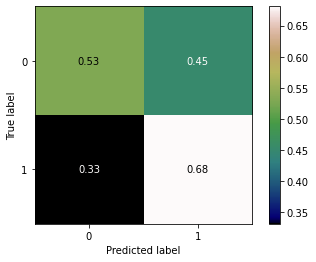

In [96]:
mdlName='SVM (WOE select Features)'
params={'degree':[3], 'max_iter' : [-1]}
SVMselectWOE, SVMselectWOEModel, SVMwoeCMD=training_models(params,SVC(random_state=1234),train[woeList], test[woeList], mdlName)

Text(0.5, 1.0, 'SVM (WoE features)')

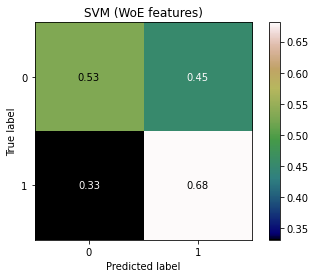

In [97]:
SVMwoeCMD.plot(cmap='gist_earth')
plt.title('SVM (WoE features)')

-----
Decision tree selected features

Function Run Time :  0:14:10.951559


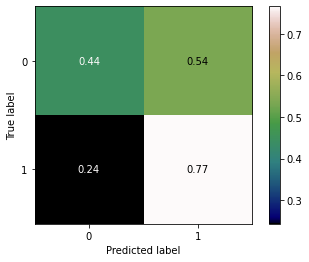

In [98]:
mdlName='SVM (Decision Tree select Features)'
params={'degree':[3], 'max_iter' : [-1]}
SVMselectDTC, SVMselectDTCModel, SVMdtcCMD=training_models(params,SVC(random_state=1234),train[dtcFeats], test[dtcFeats], mdlName)

Text(0.5, 1.0, 'SVM (Decision Tree features)')

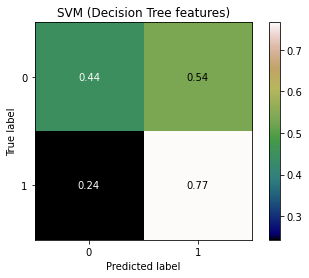

In [99]:
SVMdtcCMD.plot(cmap='gist_earth')
plt.title('SVM (Decision Tree features)')

In [100]:
# Move model result metrics into dataframe
AllModels=[RFCall, RFCselectWOE, RFCselectdtc, GBMall, GBMselectWOE, GBMselectDTC,
           LOGall, LOGselectETC, LOGselectDTC, SVMall, SVMselectWOE, SVMselectDTC]
mdls=pd.DataFrame()
for i in AllModels:
    X=pd.DataFrame.from_dict(i,orient='index').transpose()
    mdls=mdls.append(X, ignore_index=True)

In [101]:
# Training models
ModelsTrain = pd.DataFrame(columns=['Model Type','Accuracy (Train)','Precision (Train)','Recall (Train)',
                                    'ROC-AUC Score (Train)','False Positive Rate (Train)'])
trainCols=list(ModelsTrain.columns)
ModelsTrain=mdls[trainCols]
ModelsTrain

,Model Type,Accuracy (Train),Precision (Train),Recall (Train),ROC-AUC Score (Train),False Positive Rate (Train)
0,Random Forest (All features),74.48,0.75,0.73,0.74,0.24
1,Random Forest (WOE selected features),74.2,0.75,0.72,0.74,0.24
2,Random Forest (Decision Tree selected features),73.2,0.73,0.73,0.73,0.26
3,Gradient Boosting (All features),79.84,0.8,0.79,0.8,0.19
4,Gradient Boosting (WOE selected features),78.77,0.79,0.78,0.79,0.2
5,Gradient Boosting (Decision Tree selected feat...,76.44,0.77,0.76,0.76,0.23
6,Logistic Regression (All features),57.13,0.63,0.34,0.57,0.2
7,Logistic Regression (ETC features),53.27,0.57,0.25,0.53,0.19
8,Logistic Regression (Decision tree selected fe...,50.86,0.64,0.03,0.51,0.02
9,SVM (All Features),61.43,0.6,0.68,0.61,0.45


In [102]:
# Test models
ModelsTest =  pd.DataFrame(columns=['Model Type','Accuracy (Test)','Precision (Test)','Recall (Test)',
                                    'ROC-AUC Score (Test)', 'False Positive Rate (Test)'])
testCols=list(ModelsTest.columns)
ModelsTest=mdls[testCols]
ModelsTest

,Model Type,Accuracy (Test),Precision (Test),Recall (Test),ROC-AUC Score (Test),False Positive Rate (Test)
0,Random Forest (All features),74.79%,0.76,0.73,0.75,0.23
1,Random Forest (WOE selected features),74.39%,0.76,0.72,0.74,0.23
2,Random Forest (Decision Tree selected features),73.55%,0.75,0.73,0.74,0.25
3,Gradient Boosting (All features),77.99%,0.8,0.76,0.78,0.2
4,Gradient Boosting (WOE selected features),77.64%,0.79,0.77,0.78,0.21
5,Gradient Boosting (Decision Tree selected feat...,75.31%,0.76,0.75,0.75,0.23
6,Logistic Regression (All features),56.52%,0.63,0.35,0.57,0.2
7,Logistic Regression (ETC features),52.37%,0.57,0.26,0.53,0.19
8,Logistic Regression (Decision tree selected fe...,49.72%,0.64,0.03,0.51,0.02
9,SVM (All Features),61.22%,0.61,0.68,0.61,0.44


## Validation of Logistic Regression

In [103]:
paramNames=train.columns
paramNames=paramNames.drop('DEFAULT')
paramNames=list(paramNames)
prNm=[]
for i in paramNames:
    prNm.append(i)

In [104]:
eqnVals=(LOGmodelAll.coef_[0])

In [105]:
pd.options.display.precision=10
hds=['Variable','Coefficient']
LogTable=pd.DataFrame([prNm,eqnVals.astype(float)],index=hds)#,columns=hds)

In [106]:
LogTable=LogTable.transpose()
LogTable

,Variable,Coefficient
0,LIMIT_BAL,-0.0000013591
1,SEX,0.0000000146
2,Marriage_Bin,0.0000000141
3,Education_Bin,0.0000000321
4,Age_Bin,0.0000000624
5,Avg_Bill_Amt,0.0000109214
6,Avg_Pmt_Amt,-0.0000685911
7,AugPayRat,0.0000000147
8,JulPayRat,0.0000000106
9,JunPayRat,0.0000008211


In [107]:
LOGmodelAll.get_params

<bound method BaseEstimator.get_params of LogisticRegression(penalty='l1', random_state=1234, solver='saga')>

In [108]:
def valModel(X,name):
    clf=LogisticRegression(penalty='l1',solver='saga',random_state=1234)
    dfTrain=train.copy(deep=True)
    trainDefault=dfTrain['DEFAULT']
    dfTrain.pop('DEFAULT')
    dfX=X.copy(deep=True)
    dfY=dfX['DEFAULT']
    dfX.pop('DEFAULT')
    clf.fit(dfTrain,trainDefault)
    y_pred=clf.predict(dfX)
    cm=confusion_matrix(y_true=dfY, y_pred=y_pred)
    cm=cm/cm.astype(np.float32).sum(axis=1)
    CMD=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    CMD.plot(cmap='gist_earth')
    plt.show()
    Logmodel={}
    Logmodel['Dataset'] = name
    Logmodel['Accuracy'] = str(round((accuracy_score(dfY, y_pred)*100),2)) + "%"
    Logmodel['Precision'] = round(precision_score(dfY,y_pred),2)
    Logmodel['Recall'] = round(recall_score(dfY,y_pred),2)
    Logmodel['ROC-AUC Score'] = round(roc_auc_score(dfY, y_pred),2)
    Logmodel['False Positive Rate']=round(cm[0,1]/(cm[0,1]+cm[0,0]),2)
    return Logmodel, y_pred

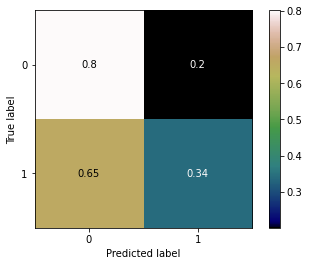

In [109]:
trMdl, trnY=valModel(train,'Train')

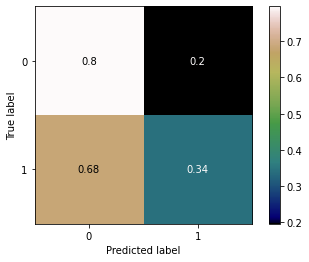

In [110]:
tstMdl, tstY=valModel(test,'Test')

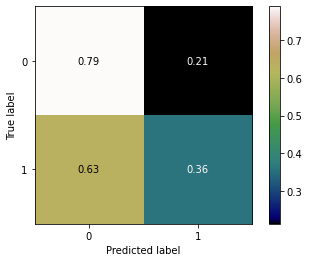

In [111]:
valMdl, valY=valModel(validate,'Validation')

In [112]:
FinalModels =  pd.DataFrame(columns=['Dataset','Accuracy','Precision','Recall','ROC-AUC Score',
                               'False Positive Rate'])
FinalModels=FinalModels.append(trMdl, ignore_index=True)
FinalModels=FinalModels.append(tstMdl, ignore_index=True)
FinalModels=FinalModels.append(valMdl, ignore_index=True)
FinalModels

,Dataset,Accuracy,Precision,Recall,ROC-AUC Score,False Positive Rate
0,Train,57.18%,0.63,0.34,0.57,0.20
1,Test,56.52%,0.64,0.34,0.57,0.20
2,Validation,57.67%,0.63,0.36,0.58,0.21


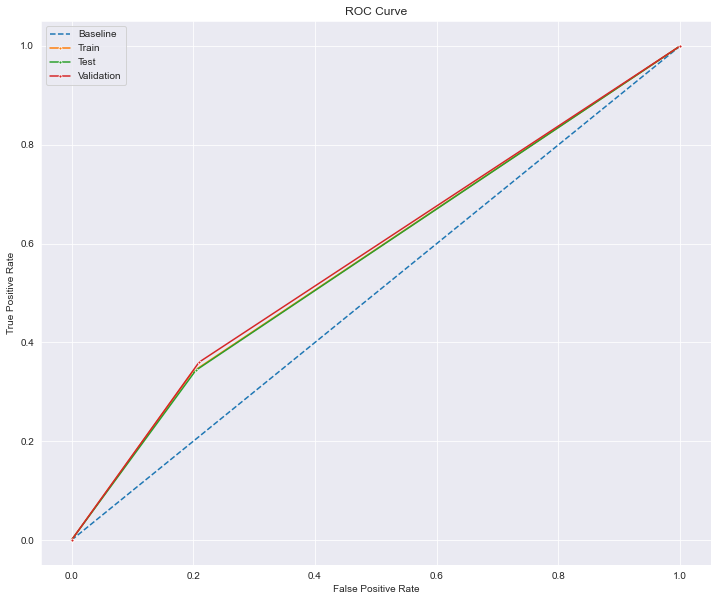

In [113]:
sns.set_style('darkgrid')
dfYtrain=trainDefault
dfYtest=testDefault
dfYval = validateDefault
noDefTrain=[0 for _ in range(len(trnY))]
trnNoDef_fpr, trnNoDef_tpr, _ = roc_curve(trnY,noDefTrain)
trnDef_fpr, trnDef_tpr, _ = roc_curve(dfYtrain,trnY)
tstDef_fpr, tstDef_tpr, _ = roc_curve(dfYtest,tstY)
valDef_fpr, valDef_tpr, _ = roc_curve(dfYval,valY)
fig, ax = plt.subplots(figsize=(12,10))
sns.lineplot(trnNoDef_fpr, trnNoDef_tpr, ax=ax, linestyle='--',label='Baseline')
sns.lineplot(trnDef_fpr,  trnDef_tpr, ax=ax, marker='.',label='Train')
sns.lineplot(tstDef_fpr,  tstDef_tpr, ax=ax, marker='.',label='Test')
sns.lineplot(valDef_fpr,  valDef_tpr, ax=ax, marker='.',label='Validation')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
## add AUC scores to legend, make legend bigger

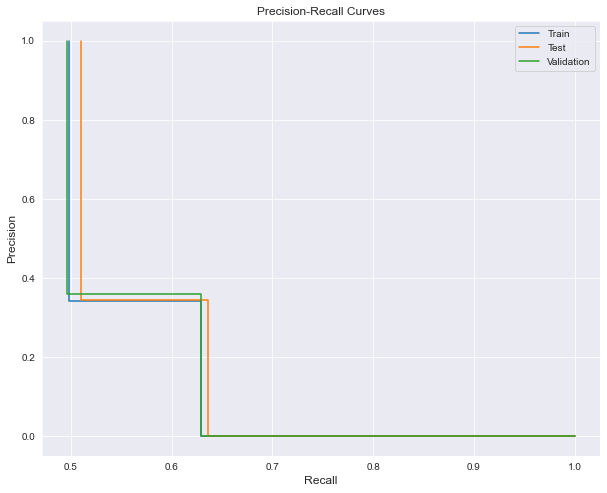

In [114]:
## Precision, recall curve
fig, ax = plt.subplots(figsize=(10,8))
trnPrec, trnReca, _ = precision_recall_curve(dfYtrain,trnY)
tstPrec, tstReca, _ = precision_recall_curve(dfYtest,tstY)
valPrec, valReca, _ = precision_recall_curve(dfYval,valY)
sns.lineplot(trnPrec, trnReca, ax=ax,drawstyle='steps-pre',label='Train')
sns.lineplot(tstPrec, tstReca, ax=ax,drawstyle='steps-pre',label='Test')
sns.lineplot(valPrec, valReca, ax=ax,drawstyle='steps-pre',label='Validation')
plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision-Recall Curves", fontsize=12)
plt.legend()
plt.show()
## add precision scores into legend, move legend closer to graph/make figure smaller, make legend bigger

Kolmogorov-Smirnov (KS) statistic compares the distribution of events (defaulting) and non-event (not defaulting) and returns the max difference. If the KS statistic is close to 0, then there is not a significant difference and the model is not accurate enough.

In [115]:
def ks(data=None,target=None, prob=None):
    data['target0']=1-data[target]
    data['bucket']=pd.qcut(data[prob], 20)
    grouped=data.groupby('bucket', as_index = False)
    kstable=pd.DataFrame()
    kstable['Min Probability']=grouped.min()[prob]
    kstable['Max Probability']=grouped.max()[prob]
    kstable['Target (Y=1)']=grouped.sum()[target]
    kstable['NonTarget (Y=0)']=grouped.sum()['target0']
    kstable=kstable.sort_values(by="Min Probability", ascending=False).reset_index(drop=True)
    kstable['Target Density']=(kstable['Target (Y=1)']/data[target].sum()).apply('{0:.2%}'.format)
    kstable['NonTarget Density']=(kstable['NonTarget (Y=0)']/data['target0'].sum()).apply('{0:.2%}'.format)
    kstable['Target CDF']=(kstable['Target (Y=1)']/data[target].sum()).cumsum()
    kstable['NonTarget CDF']=(kstable['NonTarget (Y=0)']/data['target0'].sum()).cumsum()
    kstable['KS Stat']=np.round(kstable['Target CDF']-kstable['NonTarget CDF'], 3) * 100
    #Formating
    kstable['Target CDF']=kstable['Target CDF'].apply('{0:.2%}'.format)
    kstable['NonTarget CDF']=kstable['NonTarget CDF'].apply('{0:.2%}'.format)
    kstable.index=range(1,21)
    kstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 9)
    print(kstable)
    return(kstable)

In [116]:
#Train
random.seed(1234)
Xtrain=train.copy()
p=[]
for i in range(len(Xtrain)):
    x=random.random()
    p.append(x)
Xtrain.insert(len(Xtrain.columns),'p',p,True)
ksTrain = ks(data=Xtrain,target="DEFAULT", prob="p")

        Min Probability  Max Probability  Target (Y=1)  NonTarget (Y=0)  \
Decile                                                                    
1          0.9480083064     0.9999733260           788              850   
2          0.8998968017     0.9479889996           829              809   
3          0.8481376324     0.8998442600           819              819   
4          0.7972523147     0.8481132865           838              800   
5          0.7477888388     0.7972273468           806              832   
6          0.6965982825     0.7477445801           794              844   
7          0.6449272110     0.6965977117           825              813   
8          0.5963758655     0.6449026167           824              814   
9          0.5493104350     0.5963614188           772              866   
10         0.5003762553     0.5492910264           823              815   
11         0.4512785875     0.5003654536           838              800   
12         0.4006137798  

In [117]:
# Test
random.seed(4321)
Xtest=test.copy()
p=[]
for i in range(len(Xtest)):
    x=random.random()
    p.append(x)
Xtest.insert(len(Xtest.columns),'p',p,True)
ksTest = ks(data=Xtest,target="DEFAULT", prob="p")

        Min Probability  Max Probability  Target (Y=1)  NonTarget (Y=0)  \
Decile                                                                    
1          0.9505914778     0.9999942593           238              228   
2          0.9015608863     0.9504701133           250              216   
3          0.8520378065     0.9015482225           257              208   
4          0.8045711001     0.8519676713           229              237   
5          0.7548530420     0.8044888762           246              219   
6          0.7028751440     0.7547876976           229              237   
7          0.6538050114     0.7028245422           232              234   
8          0.5992360128     0.6536516144           253              212   
9          0.5518550654     0.5992143973           229              237   
10         0.5042036121     0.5518159735           225              240   
11         0.4519771727     0.5041919775           237              229   
12         0.4004429624  

In [118]:
# Validate
random.seed(2314)
Xval=validate.copy()
p=[]
for i in range(len(Xval)):
    x=random.random()
    p.append(x)
Xval.insert(len(Xval.columns),'p',p,True)
ksVal = ks(data=Xval,target="DEFAULT", prob="p")

        Min Probability  Max Probability  Target (Y=1)  NonTarget (Y=0)  \
Decile                                                                    
1          0.9474526255     0.9995587742           117              116   
2          0.9000084976     0.9469475572           120              113   
3          0.8453004675     0.8994881972           107              125   
4          0.7960682162     0.8451438468           100              133   
5          0.7468586262     0.7958003573           113              120   
6          0.6983498294     0.7466659608           108              124   
7          0.6442407422     0.6979084678           102              131   
8          0.5931301272     0.6442112179           105              128   
9          0.5437000121     0.5929811184           113              119   
10         0.4879115845     0.5434135806           128              105   
11         0.4380981244     0.4875268438           107              126   
12         0.3884903523  